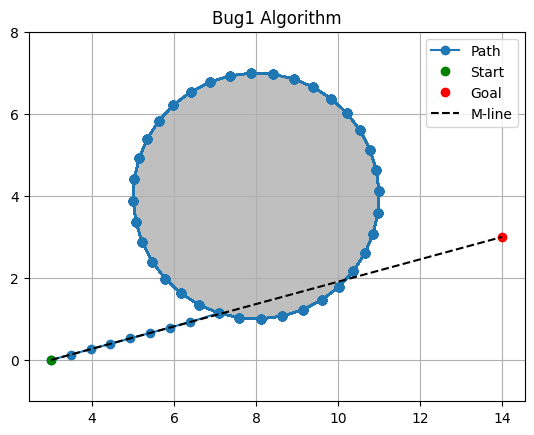

In [5]:
##BUG1

import matplotlib.pyplot as plt
import numpy as np

# Define obstacle, start, and goal
obstacle_center = np.array([8, 4])
obstacle_radius = 3
start = np.array([3, 0])
goal = np.array([14, 3])
path = [start.copy()]

# Parameters
step_size = 0.5
threshold = 0.3
max_steps = 1000

current_pos = start.copy()
state = 'move_to_goal'

def reached_goal(pos):
    return np.linalg.norm(pos - goal) < step_size

def sense_collision(pos):
    return np.linalg.norm(pos - obstacle_center) <= obstacle_radius + threshold

def follow_boundary(pos, angle_step=10):
    vec = pos - obstacle_center
    angle = np.arctan2(vec[1], vec[0])
    new_angle = angle + np.deg2rad(angle_step)
    new_pos = obstacle_center + obstacle_radius * np.array([np.cos(new_angle), np.sin(new_angle)])
    return new_pos

min_dist = float('inf')
leave_point = None
circled_once = False
hit_point = None

for _ in range(max_steps):
    if reached_goal(current_pos):
        break

    if state == 'move_to_goal':
        direction = (goal - current_pos) / np.linalg.norm(goal - current_pos)
        next_pos = current_pos + step_size * direction

        if sense_collision(next_pos):
            hit_point = current_pos.copy()
            state = 'follow_boundary'
            min_dist = np.linalg.norm(current_pos - goal)
            leave_point = current_pos.copy()
            circled_once = False
        else:
            current_pos = next_pos
            path.append(current_pos.copy())

    elif state == 'follow_boundary':
        current_pos = follow_boundary(current_pos)
        path.append(current_pos.copy())

        dist = np.linalg.norm(current_pos - goal)
        if dist < min_dist:
            min_dist = dist
            leave_point = current_pos.copy()

        # Check if we returned to the hit point (i.e., did one full circle)
        if np.linalg.norm(current_pos - hit_point) < threshold and circled_once:
            state = 'move_to_goal'
            current_pos = leave_point
            path.append(current_pos.copy())
        elif np.linalg.norm(current_pos - hit_point) < threshold:
            circled_once = True

# Plotting
path = np.array(path)
fig, ax = plt.subplots()
obstacle = plt.Circle(obstacle_center, obstacle_radius, color='gray', alpha=0.5)
ax.add_patch(obstacle)
plt.plot(path[:,0], path[:,1], marker='o', label='Path')
plt.plot([start[0]], [start[1]], 'go', label='Start')
plt.plot([goal[0]], [goal[1]], 'ro', label='Goal')
plt.plot([start[0], goal[0]], [start[1], goal[1]], 'k--', label='M-line')
plt.title('Bug1 Algorithm')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


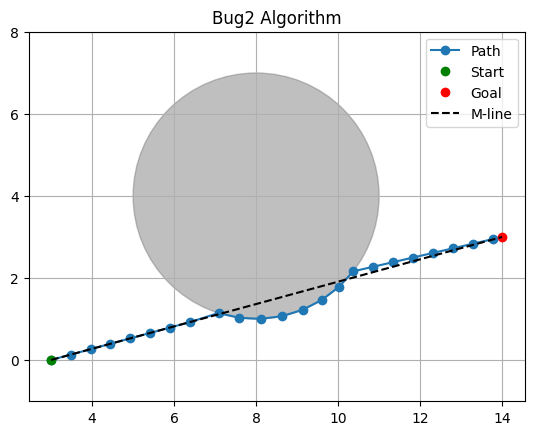

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define obstacle, start, and goal
obstacle_center = np.array([8, 4])
obstacle_radius = 3
start = np.array([3, 0])
goal = np.array([14, 3])
path = [start.copy()]

# Parameters
step_size = 0.5
threshold = 0.3
max_steps = 1000

# M-line: from start to goal
m_line_dir = (goal - start) / np.linalg.norm(goal - start)
current_pos = start.copy()
hit_point = None
leave_point = None
state = 'move_to_goal'  # or 'follow_boundary'

def on_m_line(pos):
    # Check if point is approximately on m-line (using projection and distance)
    to_start = pos - start
    proj_length = np.dot(to_start, m_line_dir)
    proj_point = start + proj_length * m_line_dir
    distance = np.linalg.norm(pos - proj_point)
    return distance < threshold

def reached_goal(pos):
    return np.linalg.norm(pos - goal) < step_size

def distance_to_goal(pos):
    return np.linalg.norm(pos - goal)

def follow_boundary(pos, angle_step=10):
    # Move along the obstacle boundary counter-clockwise
    vec = pos - obstacle_center
    current_angle = np.arctan2(vec[1], vec[0])
    new_angle = current_angle + np.deg2rad(angle_step)
    new_pos = obstacle_center + obstacle_radius * np.array([np.cos(new_angle), np.sin(new_angle)])
    return new_pos

for _ in range(max_steps):
    if reached_goal(current_pos):
        break

    vec_to_goal = goal - current_pos
    distance = np.linalg.norm(vec_to_goal)
    direction = vec_to_goal / distance

    if state == 'move_to_goal':
        next_pos = current_pos + step_size * direction
        dist_to_obstacle = np.linalg.norm(next_pos - obstacle_center)

        if dist_to_obstacle <= obstacle_radius + threshold:
            hit_point = current_pos.copy()
            state = 'follow_boundary'
            closest_point = current_pos.copy()
            min_dist = distance_to_goal(current_pos)
        else:
            current_pos = next_pos
            path.append(current_pos.copy())

    elif state == 'follow_boundary':
        next_pos = follow_boundary(current_pos)
        current_pos = next_pos
        path.append(current_pos.copy())

        # Update closest point
        dist_goal = distance_to_goal(current_pos)
        if dist_goal < min_dist:
            min_dist = dist_goal
            closest_point = current_pos.copy()

        # Check if re-entering m-line beyond hit_point
        if on_m_line(current_pos) and distance_to_goal(current_pos) < distance_to_goal(hit_point):
            state = 'move_to_goal'

# Convert to array for plotting
path = np.array(path)

# Plotting
fig, ax = plt.subplots()
obstacle = plt.Circle(obstacle_center, obstacle_radius, color='gray', alpha=0.5)
ax.add_patch(obstacle)
plt.plot(path[:,0], path[:,1], marker='o', label='Path')
plt.plot([start[0]], [start[1]], 'go', label='Start')
plt.plot([goal[0]], [goal[1]], 'ro', label='Goal')
plt.plot([start[0], goal[0]], [start[1], goal[1]], 'k--', label='M-line')  # m-line
plt.title('Bug2 Algorithm')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

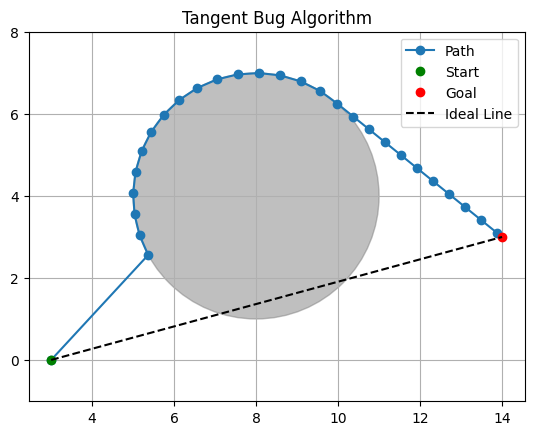

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define obstacle, start, and goal
obstacle_center = np.array([8, 4])
obstacle_radius = 3
start = np.array([3, 0])
goal = np.array([14, 3])
path = [start.copy()]

# Parameters
step_size = 0.5
threshold = 0.3
sensor_range = 6.0
max_steps = 1000

current_pos = start.copy()
state = 'move_to_goal'

def reached_goal(pos):
    return np.linalg.norm(pos - goal) < step_size

def sense_obstacle(pos):
    direction = (goal - pos) / np.linalg.norm(goal - pos)
    for r in np.linspace(0, sensor_range, int(sensor_range/0.1)):
        test_point = pos + r * direction
        if np.linalg.norm(test_point - obstacle_center) < obstacle_radius:
            return True
    return False

def follow_boundary(pos, angle_step=10):
    # Move along the obstacle boundary clockwise
    vec = pos - obstacle_center
    current_angle = np.arctan2(vec[1], vec[0])
    new_angle = current_angle - np.deg2rad(angle_step)
    new_pos = obstacle_center + obstacle_radius * np.array([np.cos(new_angle), np.sin(new_angle)])
    return new_pos

def distance_to_goal(pos):
    return np.linalg.norm(pos - goal)

min_dist = distance_to_goal(current_pos)
closest_point = current_pos.copy()

for _ in range(max_steps):
    if reached_goal(current_pos):
        break

    if state == 'move_to_goal':
        direction = (goal - current_pos) / np.linalg.norm(goal - current_pos)
        next_pos = current_pos + step_size * direction

        if sense_obstacle(current_pos):
            state = 'follow_boundary'
            min_dist = distance_to_goal(current_pos)
            closest_point = current_pos.copy()
        else:
            current_pos = next_pos
            path.append(current_pos.copy())

    elif state == 'follow_boundary':
        next_pos = follow_boundary(current_pos)
        current_pos = next_pos
        path.append(current_pos.copy())

        dist = distance_to_goal(current_pos)
        if dist < min_dist:
            min_dist = dist
            closest_point = current_pos.copy()

        # Check if we can switch back to goal-seeking
        goal_direction = (goal - current_pos) / np.linalg.norm(goal - current_pos)
        probe_point = current_pos + step_size * goal_direction
        if not sense_obstacle(current_pos) and dist < distance_to_goal(closest_point) + 1.0:
            state = 'move_to_goal'

# Convert to array for plotting
path = np.array(path)

# Plotting
fig, ax = plt.subplots()
obstacle = plt.Circle(obstacle_center, obstacle_radius, color='gray', alpha=0.5)
ax.add_patch(obstacle)
plt.plot(path[:,0], path[:,1], marker='o', label='Path')
plt.plot([start[0]], [start[1]], 'go', label='Start')
plt.plot([goal[0]], [goal[1]], 'ro', label='Goal')
plt.plot([start[0], goal[0]], [start[1], goal[1]], 'k--', label='Ideal Line')
plt.title('Tangent Bug Algorithm')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()
